#### **Final Control: QLearning EscapeGame**

Etudiant: Généreux akotenou

In [55]:
# IMPORT UTILS
import gym, os, random, warnings
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [56]:
# CREATE ENVIROMENT
class EscapeGameEnv(gym.Env):
    def __init__(self):
        super(EscapeGameEnv, self).__init__()
        labels = ["piece1", "piece2", "piece3", "piece4", "piece5", "piece6", "piece7"]
        self.action_space = spaces.Discrete(len(labels))
        self.index_to_label = {i: label for i, label in enumerate(labels)}
        self.observation_space = spaces.Discrete(7)
        self.action_space_dict = {
            #'action': ([valid inital state, ..., ...], target_state)
            "piece1": ([2   ], 1),
            "piece2": ([1, 3], 2),
            "piece3": ([2, 6], 3),
            "piece4": ([5   ], 4),
            "piece5": ([4, 6], 5),
            "piece6": ([3, 5], 6),
            "piece7": ([5, 6], 7),
        }
        self.state = None

    def reset(self):
        self.state = 2
        print("Init state ", 2)
        return self.state

    def step(self, action):
        if action not in self.observation_space:
            raise ValueError("Invalid action.")
        valid_state, next_state = self.action_space_dict[self.index_to_label[action]]
        if self.state in valid_state:
            self.state = next_state
            reward = 100 if next_state == 7 else 0
        else:
            reward = -1
        done = self.state == 7
        return self.state-1, reward, done, {'action': self.index_to_label[action], 'new_state': f"Chambre {self.state}"}

    def render(self, mode="human"):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        chamber_positions = {
            1: (1, 3),
            2: (2, 3),
            3: (3, 3),
            4: (1, 2),
            5: (2, 2),
            6: (3, 2),
            7: (2, 1),  # Exterior
        }
        room_boundaries = [
            # Horizontal borders
            [(0.5, 1.5), (3.5, 1.5)],  # Bottom row
            [(0.5, 2.5), (3.5, 2.5)],  # Middle row
            [(0.5, 3.5), (3.5, 3.5)],  # Top row
            # Vertical borders
            [(0.5, 1.5), (0.5, 3.5)],  # Left column
            [(1.5, 1.5), (1.5, 3.5)],  # Middle column
            [(2.5, 1.5), (2.5, 3.5)],  # Right column
            [(3.5, 1.5), (3.5, 3.5)],  # Far right column
        ]
        gates = [
            # Gates between rooms
            (1.5, 3.0, 0.1, 0.2),
            (2.5, 3.0, 0.1, 0.2),
            (3.0, 2.5, 0.2, 0.1),
            (3.0, 1.5, 0.2, 0.1),
            (2.5, 2.0, 0.1, 0.2),
            (1.5, 2.0, 0.1, 0.2),
            (2.0, 1.5, 0.2, 0.1),
        ]
        plt.figure(figsize=(6, 6))
        for boundary in room_boundaries:
            x_coords, y_coords = zip(*boundary)
            plt.plot(x_coords, y_coords, color="black", linewidth=1.5)
        for gate in gates:
            x, y, width, height = gate
            gate_rect = Rectangle((x, y), width, height, color="blue", zorder=5)
            plt.gca().add_patch(gate_rect)
        for state, pos in chamber_positions.items():
            if state == self.state:
                plt.scatter(*pos, color="red", s=200, zorder=6)  # Agent dot
            label = f"Chambre {state}" if state != 7 else "Exterieur"
            plt.text(pos[0], pos[1] - 0.2, label, ha="center", va="center", fontsize=10, zorder=7)
        
        plt.xlim(0.5, 3.5)
        plt.ylim(0.5, 3.5)
        plt.grid(visible=True, linestyle="--", linewidth=0.5)
        plt.title("Escape Game Environment")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.xticks(range(1, 4))
        plt.yticks(range(1, 4))
        plt.show()

In [57]:
# Q-LERNING SOLVER
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.8, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_max=1.0, epsilon_decay=0.003):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((state_size, action_size))  # Q-table

    def act(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        return np.argmax(self.q_table[state, :])  # Exploitation

    def update_q_table(self, state, action, reward, next_state):
        self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action])

    def save_q_table(self, output_path):
        """Save the Q-table to a file."""
        try:
            np.save(output_path, self.q_table)
            print(f"Q-table successfully saved to {output_path}.")
        except Exception as e:
            print(f"An error occurred while saving the Q-table: {e}")

    def load(self, input_path):
        """Load the Q-table from a file."""
        try:
            self.q_table = np.load(input_path)
            print(f"Q-table successfully loaded from {input_path}.")
        except Exception as e:
            print(f"An error occurred while loading the Q-table: {e}")

    def predict(self, state):
        """
        Choose the best action based solely on the Q-table (pure exploitation).
        No exploration is performed.
        """
        return np.argmax(self.q_table[state, :])

- Q-LEARNING SOLVER

In [58]:
# Create the environment
env = EscapeGameEnv()
state_size = env.observation_space.n
action_size = env.action_space.n

# Initialize the QLearningAgent
agent = QLearningAgent(state_size, action_size, learning_rate=0.8, gamma=0.9, epsilon=1.0, epsilon_min=0.01, epsilon_max=1.0, epsilon_decay=0.01)

# Set training parameters
episodes = 20         # Number of training episodes
max_steps = 100       # Maximum steps per episode
rewards = []          # To store the rewards for plotting

# Train the agent
for episode in tqdm(range(episodes), desc="QL-Training "):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        # Choose an action a in the current world state (s)
        action = agent.act(state)
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        next_state, reward, done, info = env.step(action)
        print(f"Info: {info}, Done: {done}, , Reward: {reward}")
        
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        agent.update_q_table(state, action, reward, next_state)

        total_reward += reward
        state = next_state
        if done:
            break
    
    # Reduce epsilon (because we need less and less exploration)
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min)*np.exp(-agent.epsilon_decay*episode) 
    rewards.append(total_reward)
print ("Score over time: " +  str(sum(rewards)/episodes))

QL-Training : 100%|██████████| 20/20 [00:00<00:00, 3532.94it/s]

Init state  2
Info: {'action': 'piece1', 'new_state': 'Chambre 1'}, Done: False, , Reward: 0
Info: {'action': 'piece2', 'new_state': 'Chambre 2'}, Done: False, , Reward: 0
Info: {'action': 'piece4', 'new_state': 'Chambre 2'}, Done: False, , Reward: -1
Info: {'action': 'piece4', 'new_state': 'Chambre 2'}, Done: False, , Reward: -1
Info: {'action': 'piece5', 'new_state': 'Chambre 2'}, Done: False, , Reward: -1
Info: {'action': 'piece3', 'new_state': 'Chambre 3'}, Done: False, , Reward: 0
Info: {'action': 'piece3', 'new_state': 'Chambre 3'}, Done: False, , Reward: -1
Info: {'action': 'piece6', 'new_state': 'Chambre 6'}, Done: False, , Reward: 0
Info: {'action': 'piece6', 'new_state': 'Chambre 6'}, Done: False, , Reward: -1
Info: {'action': 'piece1', 'new_state': 'Chambre 6'}, Done: False, , Reward: -1
Info: {'action': 'piece3', 'new_state': 'Chambre 3'}, Done: False, , Reward: 0
Info: {'action': 'piece4', 'new_state': 'Chambre 3'}, Done: False, , Reward: -1
Info: {'action': 'piece4', 'new

In [59]:
# Display the Q-table
print("Final Q-Table (episode=20):")
print(agent.q_table)

Final Q-Table (episode=20):
[[63.7625641  72.37579737 64.56887264 64.00381125 64.46377224 64.01981287
  64.18501453]
 [65.09880463 71.33102162 73.15101728 71.21712493 71.89325597 71.34400861
  71.16389359]
 [70.39962034 72.06329708 71.65937608 72.02146952 66.99143205 87.07448827
  67.6009376 ]
 [-0.96       -0.96       -0.96       -0.9984     71.424      -0.96
  -0.96      ]
 [84.7488     56.60032    81.984       0.         86.5536      0.
  99.9936    ]
 [88.99975266 88.99952443 78.87380513 88.8525865  89.856      88.97063731
  99.99999959]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]


Best path fater Q-Learning training
Init state  2


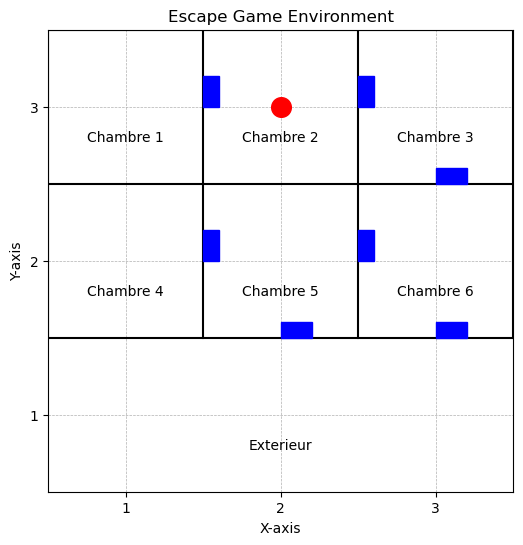

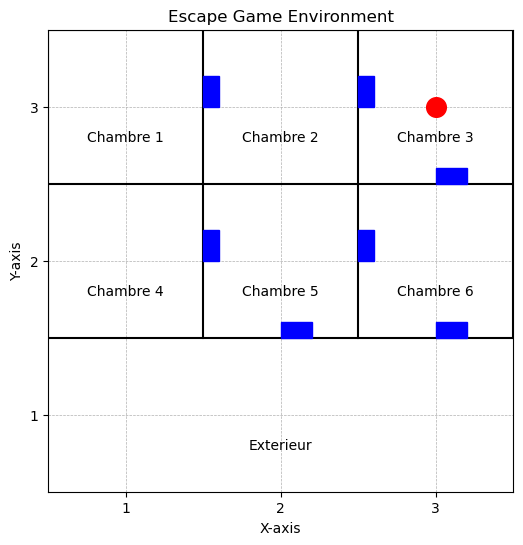

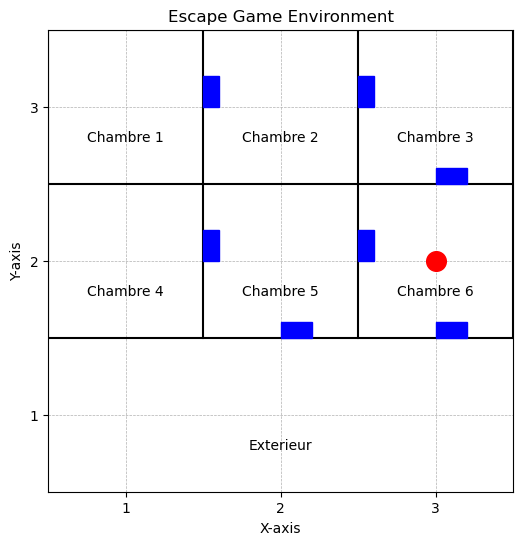

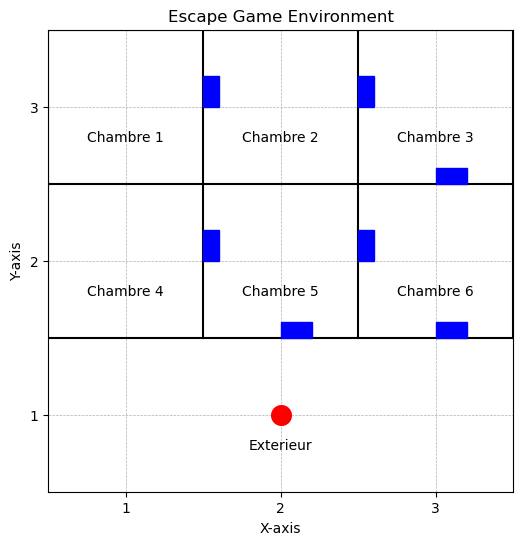

Total reward during testing: 99


In [60]:
# Test the agent after training
print("Best path fater Q-Learning training")
env = EscapeGameEnv()
state = env.reset()
done = False
total_reward = 0
max_steps = 50
for _ in range(max_steps):
    action = agent.predict(state)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    env.render()
    state = next_state
    if done:
        break
print(f"Total reward during testing: {total_reward}")

NB: Cet example d'évaluation va être rajouté au repository contenant d'autres environements et l'implementations des algorithmes de RL vu en cours: 

https://github.com/Genereux-akotenou/RLs.git

In [61]:
### END